In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
from scipy.ndimage import gaussian_filter


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import os
import sys

p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import *
from orographicPrecipitation.smith_lm import full_linear_model_saturated_monthly
from orographicPrecipitation.precip_extremes_scaling import saturation_thermodynamics, moist_adiabatic_lapse_rate, pars



In [14]:
elev=xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/GMTED2010_15n015_00625deg.nc")

## Understanding oscillations

In [15]:


EPS = np.finfo(float).eps
orog_precise=xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/GMTED2010_15n015_00625deg.nc").elevation
orog1 = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z/9.80665
m_per_degreelat = 6370*1e3*np.pi/180
def linear_model_saturated(elevation,dx):
    temp_surface = np.array([300.])
    ps=            np.array([1e5 ])
    gamma_m = moist_adiabatic_lapse_rate(temp_surface,ps,'era')
    gamma = 0.99*gamma_m
    Hw,Cw = HwCw(temp_surface,ps,gamma)
    param = {"latitude":40.,
              "p0":0., #assume no background precip rate
              "windspeed":10.,
              "tau_c":2000.,
              "tau_f":2000.,
              "nm":np.sqrt(9.81/temp_surface*(gamma_m[0]-gamma)), #approximate formula, see Smith 2004
              "hw":Hw[0],
              "cw":Cw[0]
             }
    
    pra = compute_orographic_precip(np.array(elevation), dx, **param)*24 #convert mm/hr into mm/day
    return pra

def HwCw(temp_surface,ps,gamma):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    gamma_m = moist_adiabatic_lapse_rate(temp_surface,ps,'era')
    es,_,_,L = saturation_thermodynamics(temp_surface,ps,'era')
    Hw = pars('gas_constant_v')*temp_surface**2/(L*gamma)
    Cw = es/(pars('gas_constant')*temp_surface)*gamma_m/gamma
    return Hw,Cw

def compute_orographic_precip(elevation, dx, **param):
    # --- wind components
    u0 = param['windspeed']
    # --- other factors
    f_coriolis = 2 * 7.2921e-5 * np.sin(param['latitude'] * np.pi / 180)

    # --- pad raster boundaries prior to FFT
    calc_pad = int(np.ceil(((sum(elevation.shape))) / 2) / 100 * 100)
    pad = min([calc_pad, 200])
    h = np.pad(elevation, pad, 'constant')
    nx = len(h)
    
    # --- FFT
    hhat = np.fft.fft(h)
    x_n_value = np.fft.fftfreq(nx, (1. / nx))
    x_len = nx * dx
    kx_line = 2 * np.pi * x_n_value / x_len
    kx = kx_line

    # --- vertical wave number (m)
    sigma = kx * u0

    mf_num = param['nm']**2 - sigma**2
    mf_den = sigma**2 - f_coriolis**2

    # numerical stability
    mf_num[mf_num < 0] = 0.
    mf_den[(mf_den < EPS) & (mf_den >= 0)] = EPS
    mf_den[(mf_den > -EPS) & (mf_den < 0)] = -EPS
    sign = np.where(sigma >= 0, 1, -1)

    m = sign * np.sqrt(np.abs(mf_num / mf_den * (kx**2)))

    # --- transfer function
    P_karot = ((param['cw'] * 1j * sigma * hhat) /
               ((1 - (param['hw'] * m * 1j)) *
                (1 + (sigma * param['tau_c'] * 1j)) *
                (1 + (sigma * param['tau_f'] * 1j))))
    

    # --- inverse FFT, de-pad, convert units, add uniform rate
    P = np.fft.ifft(P_karot)
    P = np.real(P[pad:-pad])
    P *= 3600   # mm hr-1
    P += param['p0']
    P[P < 0] = 0

    return P

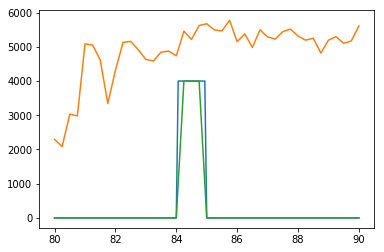

In [16]:
lonlat2 = box["nepal"]["small"]

elevation = orog_precise.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2]))
elev1d = elevation.sel(latitude=89.,method='nearest')

elevationC = orog.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2]))
elev1dC = elevationC.sel(latitude=89.,method='nearest').isel(time=0)

elev1d2 = elev1d.interp_like(elev1dC)
dx = np.cos(np.array(elevation.latitude[0])*np.pi/180.)*np.abs(np.array(elevation.latitude[1]-elevation.latitude[0]))
dxC = np.cos(np.array(elevationC.latitude[0])*np.pi/180.)*np.abs(np.array(elevationC.latitude[1]-elevationC.latitude[0]))

longs = np.array(elev1d.longitude)
elev1d = np.array(elev1d)
longsC = np.array(elev1dC.longitude)
elev1dC = np.array(elev1dC)
elev1d2 = np.array(elev1d2)

elev1dC = 4000*(longsC<85)*(longsC>84)#4000*np.exp(-10*(80-longsC)**2) #1000*(np.cos(2.4*longsC-85)+1)*
elev1d = 4000*(longs<85)*(longs>84)#4000*np.exp(-10*(80-longs)**2)

plt.plot(longs,elev1d)
plt.plot(longsC,elev1d2)
plt.plot(longsC,elev1dC)

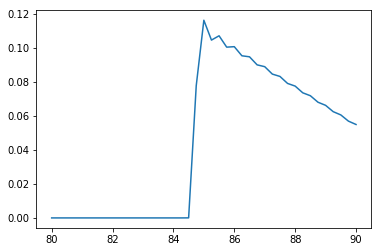

In [19]:
#elev1dC = np.cos(longsC-85)
pr=linear_model_saturated(elev1dC,dxC) 
plt.plot(longsC,pr)

#pr


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


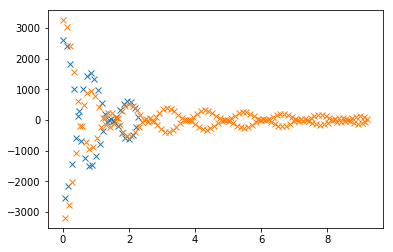

In [18]:
def f(elevation,dx):
    calc_pad = int(np.ceil(((sum(elevation.shape))) / 2) / 100 * 100)
    pad = min([calc_pad, 200])
    h = np.pad(elevation, pad, 'constant')
    hhat = np.fft.rfft(h)
    freqs = np.fft.rfftfreq(len(h),dx)
    return freqs,hhat

#elev1d = np.exp(-10*np.linspace(0,10,1000))
#elev1dC = np.exp(-10*np.linspace(0,10,100))
#dx = 1000
#dxC = 10*dx

freqs,hhat = f(elev1dC,dxC)
freqs2,hhat2 = f(elev1d,dx)

fig = plt.figure()
plt.plot(freqs,hhat*dxC,'x')
plt.plot(freqs2,hhat2*dx,'x')


In [116]:
dxC

0.21650635094610968